# Flight Price Prediction

## 0. Installing libraries

In [9]:
!pip install ydf xgboost catboost lightgbm kagglehub


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## 1. Importing Libraries

In [10]:
# Imports
import kagglehub
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# ML Models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
#import ydf
#from ydf import RandomForestLearner, DecisionTreeLearner, GradientBoostedTreesLearner
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression

import warnings

warnings.filterwarnings('ignore')

## 2. Load Dataset

In [28]:
path = kagglehub.dataset_download("shubhambathwal/flight-price-prediction")
file_paths = [os.path.join(path, p) for p in os.listdir(path)]
data = pd.read_csv(file_paths[1])

print("Dataset Shape:", data.shape)
data.head()

Dataset Shape: (300153, 12)


,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


## 3. Explorartory Data Analysis

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        300153 non-null  int64  
 1   airline           300153 non-null  object 
 2   flight            300153 non-null  object 
 3   source_city       300153 non-null  object 
 4   departure_time    300153 non-null  object 
 5   stops             300153 non-null  object 
 6   arrival_time      300153 non-null  object 
 7   destination_city  300153 non-null  object 
 8   class             300153 non-null  object 
 9   duration          300153 non-null  float64
 10  days_left         300153 non-null  int64  
 11  price             300153 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 27.5+ MB


In [30]:
data.describe()

,Unnamed: 0,duration,days_left,price
count,300153.000000,300153.000000,300153.000000,300153.000000
mean,150076.000000,12.221021,26.004751,20889.660523
std,86646.852011,7.191997,13.561004,22697.767366
min,0.000000,0.830000,1.000000,1105.000000
25%,75038.000000,6.830000,15.000000,4783.000000
50%,150076.000000,11.250000,26.000000,7425.000000
75%,225114.000000,16.170000,38.000000,42521.000000
max,300152.000000,49.830000,49.000000,123071.000000


In [31]:
data.isnull().sum()

Unnamed: 0          0
airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64

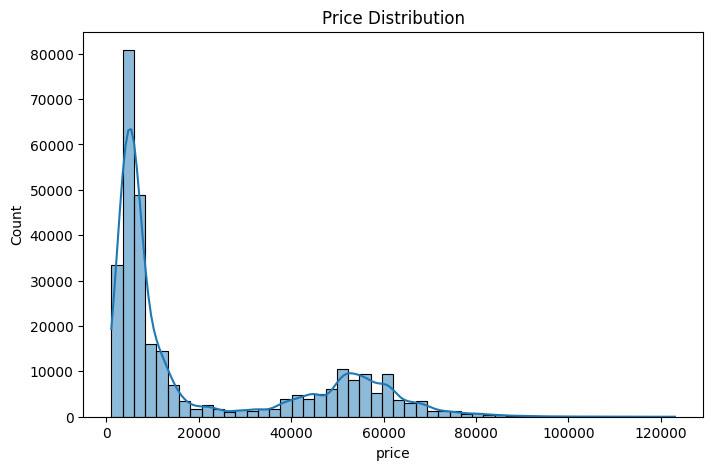

In [32]:
plt.figure(figsize=(8,5))
sns.histplot(data['price'], bins=50, kde=True)
plt.title("Price Distribution")
plt.show()

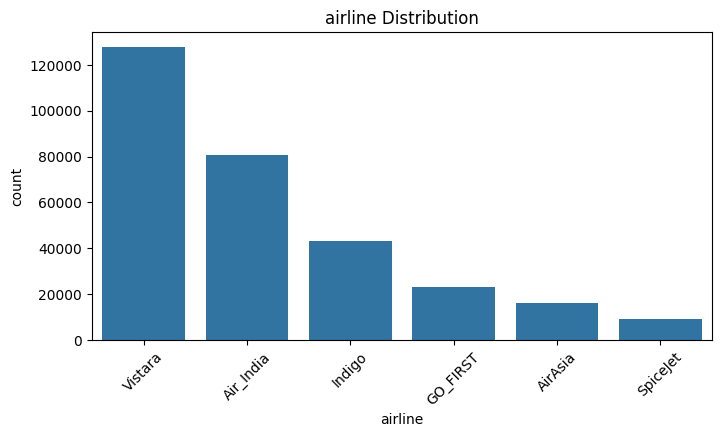

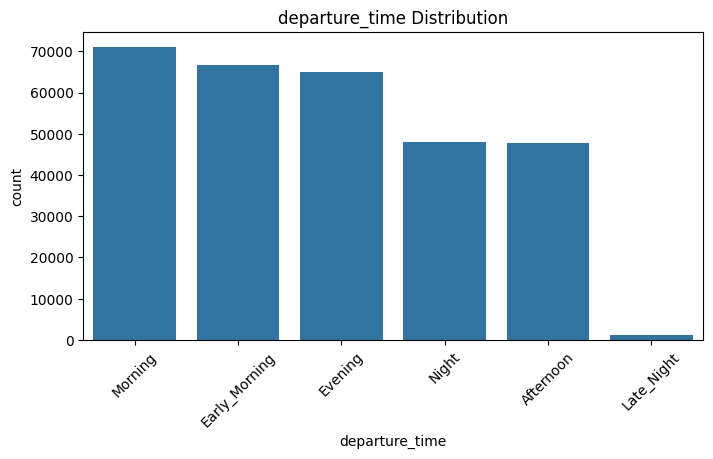

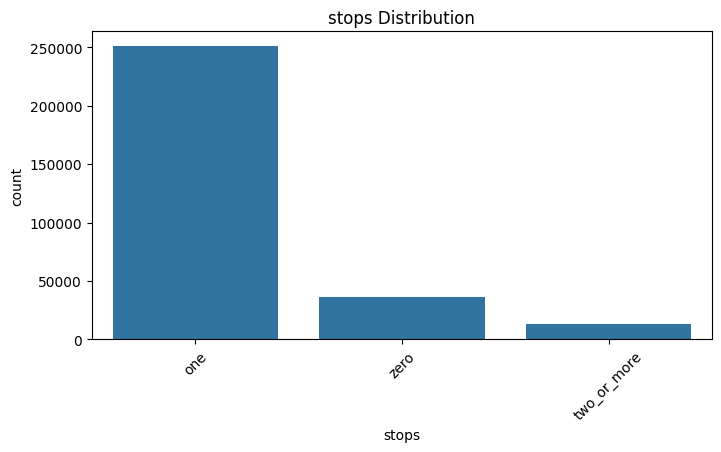

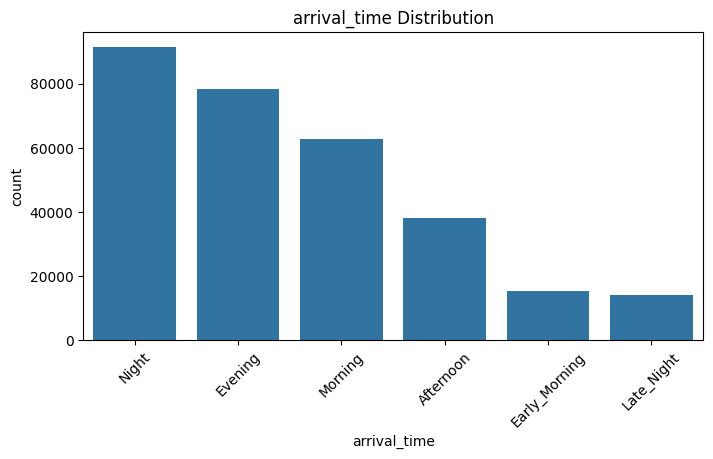

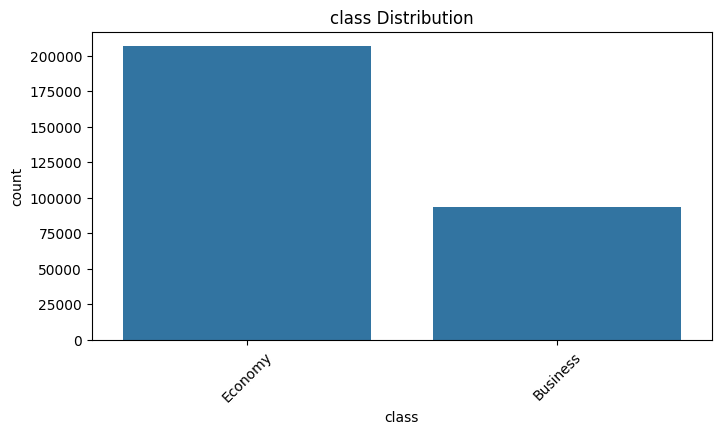

In [33]:
categorical_cols = ['airline','departure_time','stops','arrival_time','class']
for col in categorical_cols:
    plt.figure(figsize=(8,4))
    sns.countplot(data=data, x=col, order=data[col].value_counts().index)
    plt.title(f"{col} Distribution")
    plt.xticks(rotation=45)
    plt.show()


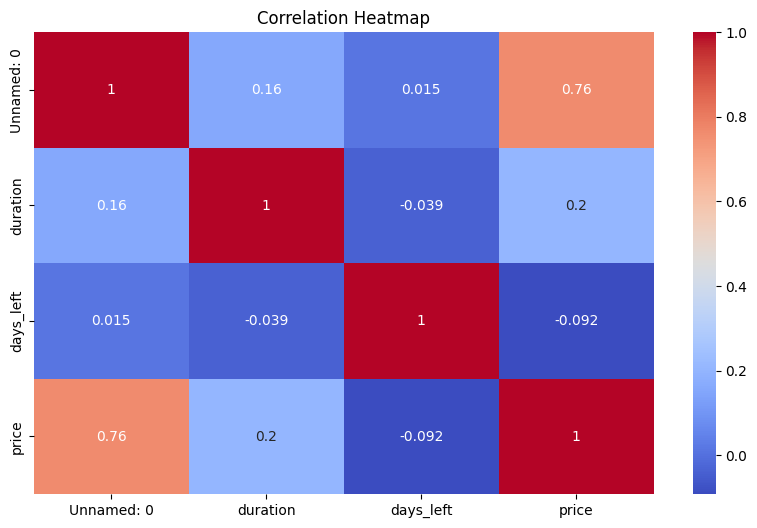

In [34]:
plt.figure(figsize=(10,6))
sns.heatmap(data.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

## 4. Feature Engineering

In [35]:
from geopy.geocoders import Nominatim

def get_lat_long(city_name):
    geolocator = Nominatim(user_agent="geoapi")
    location = geolocator.geocode(city_name + ", India")
    return (location.latitude, location.longitude) if location else (0, 0)

In [36]:
cities = data['destination_city'].unique()
coordinates = {city: get_lat_long(city) for city in cities}

In [37]:
data['source_latitude'] = data['source_city'].map(lambda x: coordinates.get(x, (0,0))[0])
data['source_longitude'] = data['source_city'].map(lambda x: coordinates.get(x, (0,0))[1])
data['destination_latitude'] = data['destination_city'].map(lambda x: coordinates.get(x, (0,0))[0])
data['destination_longitude'] = data['destination_city'].map(lambda x: coordinates.get(x, (0,0))[1])

In [ ]:
def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2-lat1, lon2-lon1
    a = math.sin(dlat/2)**2 + math.cos(lat1)*math.cos(lat2)*math.sin(dlon/2)**2
    return 6371 * 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))

data['Distance'] = data.apply(lambda row: haversine(row['source_latitude'], row['source_longitude'], 
                                                       row['destination_latitude'], row['destination_longitude']), axis=1)

## 5. Data Preprocessing 

In [ ]:
features = ['airline','departure_time','stops','arrival_time','class','duration',
            'source_latitude','source_longitude','destination_latitude','destination_longitude','Distance']
target = 'price'

df = data[features + [target]]

In [ ]:
encoders = {}
cols_to_encode = ['airline','departure_time','stops','arrival_time','class']
for col in cols_to_encode:
    encoder = OneHotEncoder(handle_unknown='ignore')
    
    # One-hot encode column
    reshaped = df[[col]]  # needs to be 2D
    encoded = encoder.fit_transform(reshaped)
    
    # Get new column names
    encoded_cols = encoder.get_feature_names_out([col])
    
    # Convert to DataFrame
    encoded_df = pd.DataFrame(encoded, columns=encoded_cols, index=df.index)
    
    # Replace the original column with its one-hot columns
    df_encoded = df_encoded.drop(columns=[col])
    df_encoded = pd.concat([df_encoded, encoded_df], axis=1)
    
    # Save encoder
    encoders[col] = encoder

In [ ]:
data['stops']

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)
X_train, y_train = train_df.drop(target, axis=1), train_df[target]
X_test, y_test = test_df.drop(target, axis=1), test_df[target]

## 6. Model Training and Evaluation

In [ ]:
results = {}

def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    #train scores
    preds = model.predict(X_train)
    r2 = r2_score(y_train, preds)
    rmse = mean_squared_error(y_train, preds)**0.5
    mae = mean_absolute_error(y_train, preds)
    print(f"{name} Train R2: {round(r2,4)}")
    print(f"{name} Train RMSE: {round(rmse,2)}")
    print(f"{name} Train MAE: {round(mae,2)}")
    
    #test scores
    preds = model.predict(X_test)
    r2 = r2_score(y_test, preds)
    rmse = mean_squared_error(y_test, preds)**0.5
    mae = mean_absolute_error(y_test, preds)
    print(f"{name} Test R2: {round(r2,4)}")
    print(f"{name} Test RMSE: {round(rmse,2)}")
    print(f"{name} Test MAE: {round(mae,2)}")
    results[name] = {"R2": r2, "RMSE": rmse, "MAE": mae}
    return model

In [ ]:
lin_reg = evaluate_model("Linear Regression", LinearRegression(), X_train, y_train, X_test, y_test)

In [ ]:
#evaluate_model("Decision Tree", DecisionTreeLearner(label="price", task=ydf.Task.REGRESSION).train(train_df), X_train, y_train, X_test, y_test)

In [ ]:
#evaluate_model("Random Forest", RandomForestLearner(label="price", task=ydf.Task.REGRESSION).train(train_df), X_train, y_train, X_test, y_test)

In [ ]:
#evaluate_model("Gradient Boosted Trees", GradientBoostedTreesLearner(label="price", task=ydf.Task.REGRESSION).train(train_df), X_train, y_train, X_test, y_test)

In [ ]:
dtree = evaluate_model("DecisionTree", DecisionTreeRegressor(), X_train, y_train, X_test, y_test)

In [ ]:
rf = evaluate_model("Random Forest", RandomForestRegressor(), X_train, y_train, X_test, y_test)

In [ ]:
xgb = evaluate_model("XGBoost", XGBRegressor(), X_train, y_train, X_test, y_test)

In [ ]:
cbm = evaluate_model("CatBoost", CatBoostRegressor(verbose=0), X_train, y_train, X_test, y_test)

In [ ]:
lgb = evaluate_model("LightGBM", LGBMRegressor(), X_train, y_train, X_test, y_test)

## 7. Model Comparison

In [ ]:
results_df = pd.DataFrame(results).T.sort_values("R2", ascending=False)
print(results_df)

plt.figure(figsize=(10,6))
sns.barplot(x=results_df.index, y="R2", data=results_df)
plt.title("Model R² Comparison")
plt.xticks(rotation=45)
plt.show()

## 🔮 Inference / Prediction

In [ ]:
import pandas as pd

def make_predictions(model, encoders, df, cols_to_encode, target_col=None,name="Model",):
    df = df.copy()

    for col in cols_to_encode:
        if col in df.columns and col in encoders:
            df[col] = df[col].map(
                lambda x: encoders[col].transform([x])[0] 
                if x in encoders[col].classes_ else -1
            )

    if target_col and target_col in df.columns:
        df = df.drop(columns=[target_col])

    preds = model.predict(df)
    return print(f"{name}:",preds[0])

In [ ]:
test = {
    'airline': ['SpiceJet'],
    'departure_time': ['Evening'],
    'stops': ['zero'],
    'arrival_time': ['Night'],
    'class': ['Economy'],
    'duration':[2.17],
    'source_latitude': [28.6273928],
    'source_longitude': [77.1716954],
    'destination_latitude': [19.054999],
    'destination_longitude': [72.8692035],
    'Distance': [1150.5283183803408]
}

test_df = pd.DataFrame(test)
test_df

In [ ]:
for model_n, model in zip(results.keys(),[lin_reg, dtree, rf, xgb, cbm, lgb]):
    pred = make_predictions(
        model=model,                
        encoders=encoders,             
        df=test_df,
        cols_to_encode=cols_to_encode, 
        target_col=None,
        name = model_n
    )

In [ ]:
df